# Computational Bioengineering
<hr>

The course is derived from the course [Biological Circuit Design by Michael Elowitz and Justin Bois, 2020 at Caltech](http://be150.caltech.edu/2020/content/index.html).

The original course material has been changed by [Matthias Fuegger](http://www.lsv.fr/~mfuegger/) and [Thomas Nowak](https://www.thomasnowak.net).


## About this course

Goal of this course is to provide you with means to understand, analyze, and design basic genetic circuits
in cells.
In chapter 1 we start with basic principles of genetic control and discuss:
- cell principles
- circuit principles
- mathematical models to describe genetic circuits
 - steady state and dynamic behavior
 - separation of time scales
- regulation principles
 - activation & repression
 - their implications for the design of new circuits


## Coding setup

We will stick to Python 3 code that can be run stand-alone at your computer whenever possible.
When running the code locally on your computer, we suggest to use a virtual environment.
We will install several libraries and a virtual environment helps to not interfere with the system's Python libraries.

For [venv](https://docs.python.org/3/library/venv.html) this is done by running this in the directory that will be used for the lecture:
```sh
python -m venv venv
. ./venv/bin/activate
```

Next let's load some libraries we will need for the course.

In [ ]:
# in case you need to install a library run a command like:
# %pip install numpy
# %pip install matplotlib
# %pip install mobspy

# imports
import numpy as np
import matplotlib.pyplot as plt

# configure notebook figures
# remove it in case you run it as stand-alone code
%matplotlib inline

  Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.10.6-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp312-cp312-macosx_10_13_universal2.whl.metadata (109 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.4-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.6-cp312-cp312-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_

# 1. Introduction


## Cells

A cell is a membrane-bound collection of interacting molecules.
Interaction can change the composition of molecules and their properties. At the level of chemical species, the reactions are mass preserving. An example for a chemical reaction is that two interacting molecules form a dimer upon interaction.

At an abstract level, these processes can be interpreted as a cell
- sensing its environment
- processing the stimuli
- adapting its behavior, e.g., changing its growth rate, secreting molecules, or moving away from a repellent 

### Models
To describe (aspects of) a cell's behavior models on different levels of abstraction have been used. During the course we will discuss some of these. An example is Chemical Reaction Networks (CRNs) that describe the evolution of species in a cell via reactions that occur among the species.
Reactions modify, generate, and consume other species.
While such a (chemically inspired) model may seem mostly relevant at a molecular level, we will see that one can also use it at more abstract levels. A core difference there is that we often drop the assumption that mass is preserved in the reactions.
More on this later in the course.

### A model organism: the bacteria _Escherichia coli_ (_E. coli_)
While many of the concepts covered in the course are general to a wide class of cells, we will
often refer to [_E. coli_](https://en.wikipedia.org/wiki/Escherichia_coli) as an example.
_E. coli_ is a gram negative bacterium. It has an inner and outer membrane.

<figure style="width: 700px; margin: auto; padding: 20px; background-color:white;">
  <img src="https://phil.cdc.gov/PHIL_Images/10071/10071_lores.jpg" alt="E.coli">
    <figcaption><b>Fig:</b> <em>E.coli</em> (from CDC, https://phil.cdc.gov)</figcaption>
</figure>

Their shape is approximately cylindrical with round caps (rod shaped) with a radius of $0.5\mu$ and length of $2\mu m$. Their volume of about $1 \mu m^3$, or equivalently, $10^{-15} L = 1fL$.
_E. coli_ cultures [grow by cell division](https://www.youtube.com/watch?v=_5bGPa-QXV4) with a rate depending on several factors like strain, temperature, and available nutrients in the growth medium. During fast growth cells duplicate about every 20 min.

Below is a schematic of its membranes from the inside of the cell (cytoplasm, bottom in the figure) to the outside (top in the figure).

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Gram_negative_cell_wall.svg/1920px-Gram_negative_cell_wall.svg.png" alt="E.coli mombranes">
    <figcaption><b>Fig:</b> <em>E.coli</em> (from wikimedia, https://en.wikipedia.org/wiki/Gram-negative_bacteria)</figcaption>
</figure>

Recently microscopy has made significant advances in capturing high-resolution images of parts of cells. One such image you can find in [Matias, Valério RF, et al., J. of Bacteriology, 2020](https://journals.asm.org/doi/10.1128/JB.185.20.6112-6118.2003#pill-references) Fig.4. of the paper where membranes are nicely visible.

The genome of _E. coli_ is a double stranded circular DNA and varies considerably by strain.
For MG1655 (a K-12 substrain) it is 4,641,652 bp long and can be found in the
[ncbh database](https://www.ncbi.nlm.nih.gov/nuccore/U00096).

### Crowded volume
The cytoplasm of a cell should be imagined as a crowded space in contrast to molecules freely floating around.
To get an impression how densely packed it is, see this
[simulation of the cytoplasm of _E. coli_ during 15ms by McGuffee and Elcock](http://cellimagelibrary.org/images/28234).

## Pathways in _E. coli_

Reactions are typically grouped together into pathways, that describe reactions for a certain cell function. 
Examples are the modification of molecules by enzymes along _metabolic pathways_ as well as transcription and translation in _genetic pathways_.
An overview of reactions grouped into pathways is shown in the figure below.
An interactive schematic is available [here by ecocyc](https://ecocyc.org/overviewsWeb/celOv.shtml?orgid=ECOLI) and lists of pathways available, e.g., by [biocyc](https://biocyc.org/ECOLI/class-tree?object=Pathways) and
[kegg](https://www.genome.jp/kegg/pathway.html#cellular).

<figure style="width: 100%; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/ecoli_reactions.png" alt="araA in pathway">
    <figcaption><b>Fig:</b> schematic of <em>E. coli</em> pathways (from ecocyc, https://ecocyc.org/overviewsWeb/celOv.shtml?orgid=ECOLI)</figcaption>
</figure>

Below is an excerpt of reactions from a genetic pathway that includes the transcription of the araA gene.
See [here](https://ecocyc.org/gene?orgid=ECOLI&id=EG10052) for an interactive version.
These reations will play a role later on in the course.

<figure style="width: 100%; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/araA.png" alt="araA in pathway">
  <figcaption><b>Fig:</b> araA gene in pathways (from ecocyc, https://ecocyc.org/gene?orgid=ECOLI&id=EG10052)</figcaption>
</figure>




## Circuits

We may view a pathway as a system that comprises of:
- a set of input species
- a set of output species
- a set of internal species
- a set of reactions that describe the interactions among all these species

This is very similar to what is called a _circuit_ which comprises of:
- a set of input ports/nodes
- a set of output ports/nodes
- a set of internal nodes
- a set of electronic components that relate signals at the nodes to each other.

We will thus refer to a pathway as a _biological circuit_.
There are _natural_ circuits that have naturally evolved and _synthetic_ biological circuits that have been engineered into the cell.
Synthetic circuits, however, use components of naturally evolved circuits that are then either used directly or adapted for synthetic circuits.

### Signals
An _execution_ or _signal trace_ of an electronic circuit is given by the voltage $u(t)$ at each of its nodes
with respect to a ground potential over time $t$.
An execution not only depends on the circuit, but also on the circuit _environment_, interacting with the circuit via its input and output ports - in the end we want the circuit to react differently to different inputs.

A digital signal with values in $\{0,1\}$ is sometimes more convenient when designing, analyzing, and simulating a circuit and it is obtained from the analog signal by discretizing at a _threshold voltage_.

> **_Side note._**  In some contexts more than two discrete signal values are used. One such example is using 0 and 1 for strong signal values and $X$ for an intermediate signal value. This becomes relevant when signals spend a significant amount of time within value-ranges that are neither clear 0 nor 1.

Signals in a biological circuit are typically given as concentrations or counts (in a fixed volume) of species over time.
We will see that digital abstractions will also be used in biological circuits.

However, we stress that signals are not necessarily voltages and concentrations.
For example, in electrical circuits, it is sometimes more convenient to use the current $i(t)$ through a certain connection between nodes as the signal.
We may even mix signal domains and use current for the input signal and voltage for the output signal or vice versa.
Likewise, current-analogs are used in biological circuits as signals.
Examples are production rates of species
[(Aoki et al., Nature 2019)](https://www.nature.com/articles/s41586-019-1321-1)
and the number of RNA polymerases (RNAPs) that pass a certain DNA bp per time (RNAP flux)
[(Kelly et al., J. of Biological Engineering 2009)](https://jbioleng.biomedcentral.com/articles/10.1186/1754-1611-3-4),
[(Borujeni et al., Nature comm. 2020)](https://www.nature.com/articles/s41467-020-18630-2).




### Circuit components
Examples for analog electronic components are the resistor and the capacitor,
example for digital components (gates) are the inverter (INV), a NAND gate, and a NOR gate:

<figure style="width: 100%; margin: auto; padding: 20px; background-color:white;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/c/cb/Circuit_elements.svg" alt="electronic components">
  <figcaption><b>Fig:</b> Electronic circuit components (from wikimedia, https://upload.wikimedia.org/wikipedia/commons/c/cb/Circuit_elements.svg)</figcaption>
</figure>

Let us start with two analog components.
The _resistor_ with resistance $R$ between two of the circuit's nodes $p$ and $q$ relates voltage $u_{pq}(t)$ and
current $i_{pq}(t)$ accross it by
$$
u_{pq}(t) = R \cdot i_{pq}(t) \enspace.
$$

The _capacitor_ with capacitance $C$ relates voltage $u_{pq}(t)$ and current $i_{pq}(t)$ across it by
$$
i_{pq}(t) = C \cdot \frac{du_{pq}(t)}{dt} \enspace.
$$

These analog components do not have dedicated input and output ports.
They are undirected and simply restrict signals among the ports they connect in certain ways.

Thus, a priori, such a circuit thus does not have a direction.
The choice of which ports are inputs and which ones outputs is irrelevant for the executions it produces.
It is rather a convention to tell the circuit's user which node voltages we propose to vary (via the environment) to obtain a certain intended behavior at the output nodes (given that the output's environment does not interfere with this).

Additionally to the circuit components, we also need to include the _Kirchhoff current law_.
Let $p$ be a node in the circuit and $N(p)$ the set of neighboring nodes. Then,
$$
\sum_{q \in N(p)} i_{qp}(t) = 0\enspace.
$$
Further, the _Kirchhoff voltage law_ states that along a closed path $C$ of edges
in the circuit,
$$
\sum_{e \in C} u_{e}(t) = 0\enspace.
$$

### Example

Let's look at a small example, an RC circuit, shown in the figure below.

<figure style="width: 100%; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/circuit_RC.svg" alt="RC cricuit">
  <figcaption><b>Fig:</b> RC circuit</figcaption>
</figure>

We have marked the ground potential with $0$V, a dedicated input node and an output node.
Input and output signals are in terms of voltage.

The first assumption made is one about the _circuit's environment_: we have assumed that the output current is $0$A. While this may be true for some circuits, or at least approximately hold since output currents are very low, it may be violated for others.
For example, we cannot simply compose two such circuits sequentially: the assumption would most a priori be violated with a positive input current of the second instance.

For the input environment, we assume that the input voltage was $0$ V all before time $0$, and has jumped to
$1$ V at time $0$ where it remains.

We have:
\begin{align}
u_R(t)    &= R \cdot i_R(t)       \qquad&&\text{(resistor rule)}\\
i_C(t)    &= C \cdot \frac{du_{out}(t)}{dt}       \qquad&&\text{(capacitor rule)}\\
u_{in}(t) &= u_R(t) + u_{out}(t)        &&\text{(Kirchhoff voltage)}\\
i_{R}(t) &= i_C(t)        &&\text{(Kirchhoff current)}\\
\end{align}

and thus

\begin{align}
\frac{du_{out}(t)}{dt}   &= \frac{1}{RC} \left( u_{in}(t) -  u_{out}(t) \right)&& \\
u_{out}(0) &= 0  &&\text{(input environment)}
\end{align}

The change of the output $\frac{du_{out}(t)}{dt}$ is thus proportional to the difference of input and output $u_{in}(t) -  u_{out}(t)$.
If $u_{in}(t) > u_{out}(t)$, the output is corrected to increase and vice versa for $u_{in}(t) < u_{out}(t)$.

For our assumptions of an input at $1$ V, we observe that the following equation fulfills the above differential equation and initial conditions
\begin{align}
u_{out}(t) =  1 - e^{-\frac{t}{RC}} \enspace.
\end{align}
Let's plot it over time:

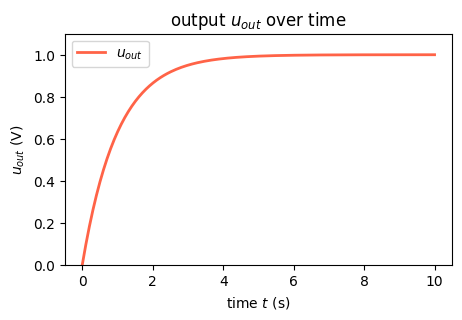

In [ ]:
# compute
t = np.linspace(0, 10, 200)
R = 1
C = 1
uout = 1 - np.exp(-t/(R*C))

# build plot
plt.figure(figsize=(5,3))
plt.title('output $u_{out}$ over time')
plt.xlabel("time $t$ (s)")
plt.ylabel("$u_{out}$ (V)")
plt.plot(t, uout, linewidth=2, color="tomato", label="$u_{out}$")
plt.ylim(0,1.1)
plt.legend()
plt.show()

## First steps: Develop intuition for the simplest gene regulation circuits

Let's turn to biological circuits.
We will start by thinking about a single gene, coding for a single corresponding protein. This minimal example will allow us to develop intuition for the dynamics of the simplest gene regulations systems and lay out a procedure that we can further extend to analyze more complex circuits. 

What protein concentration will be produced by a gene *x*? We assume that the gene will be transcribed to mRNA and those mRNA molecules will in turn be translated to produce proteins, such that new proteins are produced at a total rate $\beta$ molecules per unit time. The $x$ protein does not simply accumulate over time. It is also removed both through active degradation as well as dilution as cells grow and divide. For simplicity, we will assume that both processes tend to reduce protein concentrations through a simple first-order process, with a rate constant $\gamma$. 

The approach we are taking can be described as "phenomenological modeling." We do not explicitly represent every underlying molecular step. Instead, we assume those steps give rise to "coarse grained" relationships that we can model in a manner that is independent of many underlying molecular details. The test of this approach is whether it allows us to understand and experimentally predict the behavior of real biological systems. See [Wikipedia's article on phenomenological models](https://en.wikipedia.org/wiki/Phenomenological_model) and [this article](https://doi.org/10.1186/1741-7007-12-29) by Jeremy Gunawardena.

Thus, we can draw a diagram of our simple gene, x, with its protein being produced and removed (dashed circle):


<figure style="width: 100%; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/simplest_protein.png" alt="simplest_protein">
</figure>


Here, protein production occurs at rate $\beta$ and degradation+dilution at rate $\gamma x$. We can then write down a simple ordinary differential equation describing these dynamics:

\begin{align} 
&\frac{dx}{dt} = \mathrm{production - (degradation+dilution)} \\[1em]
&\frac{dx}{dt} = \beta - \gamma x
\end{align}

where 

\begin{align}
\gamma = \gamma_\mathrm{dilution} + \gamma_\mathrm{degradation}
\end{align}

> **_Side note (arrows in the diagram):_** The arrows resemble chemical reaction arrows. That is intended as we will later see. Precisely there are two type of arrows/reactions that we did not distinguish in the picture. The first one generates something and the second one transforms something into something. In the picture is clear what is what, but when we will use these reactions to describe systems we need to be clear. 

> **_Side note (units):_** What are the units of $x$, $\beta$, and $\gamma$? Try to find out yourself by starting with $x$ before reading on. For $x$ there is actually a choice to make. We, and most, hinted here that $x$ is a concentration (expected number for a fixed volume would be an alternative choice for probabilistic systems). We would then eed to decide which concentration we go for: numbers per volume ($1/m^3$), molar ($mol/m^3$), mass per volume ($g/m^3$), etc. While all of these make sense in different contexts, a natural choice for proteins in a small volume is numbers per volume since this number may be linked to experimental results most directly.
From there on we deduce $[x] = m^{-3}$, $[dx/dt] = m^{-3}s^{-1}$, and thus for rate constants $[\beta] = m^{-3}s^{-1}$ and $[\gamma][x] = [dx/dt]$ and thus $[\gamma] = s^{-1}$. Often we will use non-SI units like $uL^{-1}$ or $min^{-1}$, again since they can be directly linked to experimental outcomes.

> **_Side note (effective degradation rates):_**  When cells are growing, protein is removed through both degradation and dilution. For stable proteins, dilution dominates. For very unstable proteins, whose half-life is much smaller than the cell cycle period, dilution may be negligible. In bacteria, mRNA half-lives (1-10 min, typically) are much shorter than protein half-lives. In eukaryotic cells this is not necessarily true (mRNA half-lives can be many hours in mammalian cells).

> **_Side note (systematic ODEs):_**  For the eletronic circuit the ODEs were obtained systematically. Not so for the biocircuit. We will later discuss how to obtain the ODEs in a systematic way. In short outlook on this is given in the next section.

## How to get to the ODEs and how to simulate them?

We created an ODE that describes the transient behavior of the our first simple circuit. ODEs are great for modeling such dynamical systems, from very simple ones like this where we choose ODEs by hand to complex system behavior. Like every model, ODEs have limitations that we will discuss later.

> **_Question (limitations):_** Can you think of some?

Indeed there are systematic ways to derive the ODEs from more abstract system descriptions like bio-chemical reactions (a concept borrowed from chemistry). We have a full lecture on this, so only some basic principles here.

The picture showed 2 reactions as arrows:

\begin{align} 
\emptyset &\rightarrow X\\[1em]
X &\rightarrow \emptyset
\end{align}

where $\emptyset$ is short for ``nothing''.
It also specified some rates for these reactions. Since these are of some often used standard form that we will discuss in the upcoming lecture, it is enough to just state the constants $\beta$ and $\gamma$ instead of the complete rates $\beta$ and $\gamma X$. To distinguish them from the reaction rates, they are called _reaction rate constants_.

Using a library like [MobsPy](https://github.com/ROBACON/mobspy), we can now simply simulate the transient via:

Compiling model
Starting Simulator
Simulation is Over


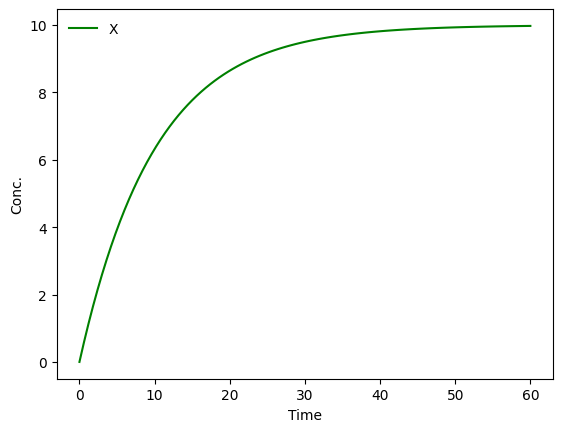

In [ ]:
# uncomment for installing:
# %pip install mobspy

import mobspy as mp

X = mp.BaseSpecies()

# parameters
volume = 1.0
beta = 1.0
gamma = 0.1

# production
mp.Zero >> X [beta]

# degradation & dilution
X >> mp.Zero [gamma]

# simulate
MySim = mp.Simulation(X)
MySim.run()

While for quick prototyping unitless simulations can be nice, let's stick to units as we derived them just before. We also set the volume of the cell to a typical volume of an _E. coli_.

In [ ]:
# E. coli volume
volume = 1.0 * mp.u("um**3")

# protein species
X = mp.BaseSpecies()

# parameters
beta = 1.0 / mp.u.min / volume
gamma = 0.1 / mp.u.min

# production
mp.Zero >> X [beta]

# degradation & dilution
X >> mp.Zero [gamma]

# simulate
MySim = mp.Simulation(X)
MySim.run(duration=60 * mp.u.min, volume=volume, unit_y = 1 / volume)

Compiling model
Starting Simulator
Simulation is Over


## Relation to electronic circuits

Let's for a moment stop and again look at the equation of the RC circuit for the case $u_{in}(t) = c$ for $t \geq 0$.
Both equations look deceptively similar:

\begin{align}
\frac{du_{out}(t)}{dt}   &=  \frac{c}{RC} -  \frac{1}{RC} \cdot u_{out}(t) && \text{ (RC circuit)}\\
\frac{dx}{dt} &= \beta - \gamma x && \text{ (gene regulation)}
\end{align}

In fact the electronic circuit behaves the same as the genetic circuit if $\beta = \frac{c}{RC}$ and $\gamma = \frac{1}{RC}$; a strange coincidence?

While a relation between the circuits is not immediate, let's consider a different, slightly adapted, electronic circuit shown below.

<figure style="width: 100%; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/circuit_RC_v2.svg" alt="RC cricuit (v2)">
  <figcaption><b>Fig:</b> RC circuit (v2)</figcaption>
</figure>

Now the _input signal_ is the input current $i_{in}(t)$ and the output signal the output voltage $u_{out}(t)$; at least for the moment.

We have,
\begin{align}
i_C(t) &= C \cdot \frac{du_{out}(t)}{dt} &&\text{ (capacitor rule)}\\
i_R(t) &= \frac{1}{R} \cdot u_{out}(t) &&\text{ (resistor rule)}\\
i_{in}(t) &= i_C(t) + i_R(t) && \text{ (Kirchhoff current)}
\end{align}

and thus
\begin{align}
C \cdot \frac{du_{out}(t)}{dt} &= i_{in}(t) - \frac{1}{R} \cdot u_{out}(t)
\end{align}

Let us change the output even further to the charge $Q(t)$ that is stored in the capacitor at time $t$.
For a capacitor with voltage $u(t)$ across it, it holds that
$$
Q(t) = C \cdot u(t) \enspace.
$$

Calling the output signal $Q_{out}$, we thus have,
\begin{align}
\frac{dQ_{out}(t)}{dt} &= i_{in}(t) - \frac{1}{RC} \cdot Q_{out}(t) \enspace.
\end{align}

Let's compare: the _input current_ $i_{in}$ now corresponds to the production rate $\beta$,
the _output charge_ $Q_{out}$ to the protein counts (per volume), and
$\frac{1}{RC}$ to the degradation and dilution rate $\gamma$.

> **_Question:_** Can you intuitively explain the relation between both the electronic and the genetic circuit? What is the unit of $i_{in}$ as an SI unit, and what is it in terms of charge $Q$? What is the unit of $\beta$?




## Solving for the steady state

Often, one of the first things we would like to know is the concentration of protein under steady state conditions. To obtain this, we set the time derivative to 0, and solve:

\begin{align}
              &\frac{dx}{dt} = \beta - \gamma x = 0 \\[1em]
\Rightarrow \,&x_{\mathrm{st}} = \beta / \gamma 
\end{align}

In other words, the steady-state protein concentration depends on the ratio of production rate to degradation rate.

## Including transcription and translation as separate steps 

This description does not distinguish between transcription and translation. However, considering both processes separately can be important in more dynamic and stochastic contexts that we will encounter later in the course. To do so, we can simply add an additional variable to represent the mRNA concentration, which is now transcribed, translated to protein, and degraded (and diluted), as shown schematically here:

<figure style="width: 550px; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/transcription_and_translation.png" alt="transcript_and_translation">
</figure>

These reactions can be described by two coupled differential equations for the mRNA (m) and protein (x):

\begin{align}
&\frac{dm}{dt} = \beta_m - \gamma_m m, \\[1em]
&\frac{dx}{dt} = \beta_p m - \gamma_p x. 
\end{align}

Now, we can  determine the steady state mRNA $m_\mathrm{st}$ and protein $x_\mathrm{st}$ concentrations straightforwardly, by setting both time derivatives to 0 and solving. We find:

\begin{align}
&m_\mathrm{st} = \beta_m / \gamma_m, \\[1em]
&x_\mathrm{st} = \frac{\beta_p m_\mathrm{st}}{\gamma_p} = \frac{\beta_p \beta_m}{\gamma_p \gamma_m}.
\end{align}

From this, we see that the steady state protein concentration is proportional to the product of the two synthesis rates and inversely proportional to the product of the two degradation rates. 

And this gives us our first design rule:

> **_Design rule:_**  the cell can control protein expression level in at least **four different ways:** It could modulate (1) transcription, (2) translation, (3) mRNA degradation or (4) protein degradation rates. Or combinations thereof.

> **_Question:_** Are there tradeoffs between these different options? Are they all used indiscriminately or is one favored in natural contexts? 

## From gene expression to gene regulation - adding a repressor

Life would be simple—perhaps too simple—if genes were simply left "on" all the time. To make things interesting the cell has to regulate them, turning their expression levels lower or higher depending on environmental conditions and other inputs. One of the simplest ways to do this is through repressors. Repressors are proteins that can bind to specific binding sites at or near a promoter to change its activity. Often the strength of their binding is contingent on external inputs. For example, the LacI repressor normally turns off the genes for lactose utilization in *E. coli*. However, in the presence of lactose in the media, a modified form of lactose binds to LacI, inhibiting its ability to repress its target genes. Thus, a nutrient (lactose) can regulate expression of genes that allow the cell to use it. (For the scientific and historical saga of this seemingly simple system, we recommend the fascinating, wonderful book ["The lac operon"](https://www.amazon.com/lac-Operon-Benno-Müller-Hill/dp/3110148307) by B. Müller-Hill.)

In the following diagram, we label the repressor R.

<figure style="width: 550px; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/repressible_gene2.png" alt="repressible_gene_2">
</figure>

The reactions we obtain are:

\begin{align}
D + R \rightleftharpoons D_{occ}
\end{align}

For the rates we again choose products of the involved species. This is again the normal form that we will often be using for rates; more to this in a dedicated lecture. 

Within the cell, the repressor binds and unbinds its target site. We assume that the expression level of the gene is lower when the repressor is bound and higher when it is unbound. The mean expression level of the gene is then proportional to the fraction of time that the repressor is unbound. 

We therefore compute the "concentration" of DNA sites in occupied or unoccupied states. (Within a single cell an individual site on the DNA is either bound or unbound, but averaged over a population of cells, we can talk about the mean occupancy of the site). Let $D$ be the concentration of unoccupied promoter, $D_\mathrm{occ}$ be the concentration of occupied promoter, and $D_\mathrm{tot}$ be the total concentration of promoter, with $D_\mathrm{tot} = D + D_\mathrm{occ}$, as required by conservation of mass.

We can also assume a **separation of timescales** between the rates of binding and unbinding of the repressor to the DNA binding site are both often fast compared to the timescales over which mRNA and protein concentrations vary.

> **_Side note (speed of being in an equilibrium):_** The method of separation of timescales is often useful to simplify an analysis or speedup a simulation. Be careful when you use it, though. Often its a good idea to run simulations with and without the assumption to quantify the error. In some contexts, such as in mammalian cells, and with CRISPRi circuits, binding and unbinding may be slow.

> **_Question (expected amounts in a cell volume):_** Estimate (by looking it up) the amounts of the involved biochemical species in the cell volume. This will be important in the following derivation. Is it the same for all repressors that you find?

All we need to know is the mean concentration of unoccupied binding sites, $D/D_\mathrm{tot}$.

Assuming we are (quickly) in an equilibrium, leads to:
\begin{align}
k_+ D R &= k_- D_\mathrm{occ} \\[1em]
\end{align}

Further, we have conservation of $D$ and $R$ species. We use $R_\mathrm{bound}$ as the concentration of bound repressors, $R_\mathrm{tot}$ as its total number, and $R$ as the unbound concentration.
\begin{align}
D_\mathrm{occ} &= D_\mathrm{tot} - D \\[1em]
R_\mathrm{bound} &= R_\mathrm{tot} - R
\end{align}

We observe that $D_\mathrm{occ} = R_\mathrm{bound}$: any occupied operator site is bound by exactly one repressor species in our basic repressor model.

For simplicity, and following common notation, we abbreviate $K_\mathrm{d} = k_- / k_+$ calling it the _dissociation constant_.
Further, we consider $x = R_{tot}$ as the system input and $y = D_\mathrm{tot}$ as its output.

Let's consider two cases, first a simplifying case that is often used. And second an exact analysis.

### Case 1: Zero or many repressors

In this case we can approximate $R \approx R_{tot}$.
\begin{align}
D R &= k_-/k_+ D_\mathrm{occ} \\[1em]
D R_\mathrm{tot} &= K_\mathrm{d} D_\mathrm{occ} \\[1em]
D R_\mathrm{tot} &= K_\mathrm{d} (D_\mathrm{tot} - D) \\[1em]
y R_\mathrm{tot} &= K_\mathrm{d} (1 - y) \\[1em]
y &= \frac{1}{1+R_\mathrm{tot}/K_\mathrm{d}} 
\end{align}

and thus finally

\begin{align}
\beta(R_\mathrm{tot}) = \beta_0 \frac{D}{D_\mathrm{tot}} = \frac{\beta_0}{1+R_\mathrm{tot}/K_\mathrm{d}}.
\end{align}

### Case 2: Exact calculation

We start with,
\begin{align}
D R &= k_-/k_+ D_\mathrm{occ} \\[1em]
D (R_\mathrm{tot} - R_\mathrm{bound}) &= K_\mathrm{d} D_\mathrm{occ} \\[1em]
\end{align}
and after some algebraic manipulation, we get
\begin{align}
y^2 D_\mathrm{tot} + y(R_\mathrm{tot} - D_\mathrm{tot} + K_\mathrm{d}) - K_\mathrm{d} &= 0
\end{align}

Using the classical
\begin{align}
y = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
\end{align}
let's check if we can rule out one solution.
While it is not necessarily $b > 0$, we observe that $-4ac > 0$ in our case, and thus $\sqrt{b^2 - 4ac} > |b|$.
We may thus disregard the "-" solution that would yield a negative concentration $y$.
Thus,
\begin{align}
y(R_\mathrm{tot}) &= \frac{-(R_\mathrm{tot} - D_\mathrm{tot} + K_\mathrm{d}) + \sqrt{(R_\mathrm{tot} - D_\mathrm{tot} + K_\mathrm{d})^2 + 4K_\mathrm{d}D_\mathrm{tot}}}{2D_\mathrm{tot}} \\[1em]
\beta(R_\mathrm{tot}) &= \beta_0 y(R_\mathrm{tot})
\end{align}

Interestingly this formula depends on $D_\mathrm{tot}$ while the simplified is independent of the number of promoters.

## Properties of the simple binding curve

This is our first encounter with a soon to be familiar function. Note that this function has two parameters: $K_\mathrm{d}$ specifies the concentration of repressor at which the response is reduced to half its maximum value. The coefficient $\beta_0$ is simply the maximum expression level, and is a parameter that multiples the rest of the function.

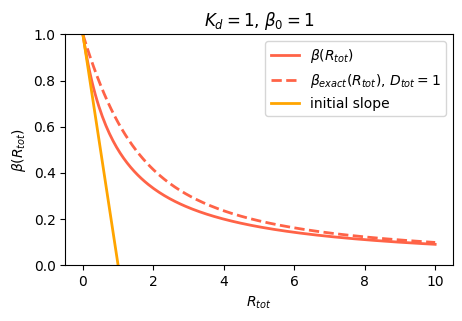

In [ ]:
# Build theoretical curves
Rtot = np.linspace(0, 10, 200)
b0 = 1
Kd = 1
beta = b0 / (1 + Rtot / Kd)
init_slope = -Rtot + 1

# exact
Dtot = 1
b = Rtot - Dtot + Kd
beta_exact = b0 * (-b + np.sqrt(b**2 + 4 * Kd * Dtot) )/ (2 * Dtot)

# Build plot
plt.figure(figsize=(5,3))
plt.title(fr'$K_d = {Kd}$, $\beta_0 = {b0}$')
plt.xlabel(r"$R_{tot}$")
plt.ylabel(r"$\beta(R_{tot})$")
plt.plot(Rtot, beta, linewidth=2, color="tomato", label=r"$\beta(R_{tot})$")
plt.plot(Rtot, beta_exact, '--', linewidth=2, color="tomato", label=fr"$\beta_{{exact}}(R_{{tot}})$, $D_{{tot}} = {Dtot}$")
plt.plot(Rtot, init_slope, linewidth=2, color="orange", label="initial slope")
plt.ylim(0,1)
plt.legend()
plt.show()

> **_Question:_** What happens if you keep increasing the number of promoters in the cell? Check it out in the above code. 

## Gene expression can be leaky

As an aside, we note that in real life, many genes never get repressed all the way to zero expression, even when you add a lot of repressor. Instead, there is a baseline, or "basal", expression level that still occurs. A simple way to model this is by adding an additional constant term, $\alpha_0$ to the expression 

\begin{align}
\beta(R_\mathrm{tot}) = \alpha_0 + \beta_0 \frac{D}{D_\mathrm{tot}} = \alpha_0 + \frac{\beta_0}{1+R_\mathrm{tot}/K_\mathrm{d}}.
\end{align}

Given the ubiquitousness of leakiness, it is important to check that circuit behaviors do not depend on the absence of leaky expression.

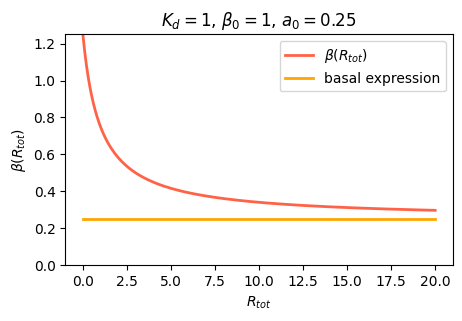

In [ ]:
# Build the theoretical curves
Rtot = np.linspace(0, 20, 200)
b0 = 1
Kd = 1
a0 = 0.25
beta = a0 + b0 / (1 + Rtot / Kd)

# Build plot
plt.figure(figsize=(5,3))
plt.title(rf"$K_{{d}} = {Kd}$, $\beta_{{0}} = {b0}$, $a_{{0}} = {a0}$")
plt.xlabel(r"$R_{tot}$")
plt.ylabel(r"$\beta(R_{tot})$")
plt.plot(Rtot, beta,
    linewidth=2,
    color="tomato",
    label=r"$\beta(R_{tot})$")
plt.plot([Rtot[0], Rtot[-1]], [a0, a0],
    linewidth=2,
    color="orange",
    label="basal expression")
plt.ylim(0, beta.max())
plt.legend()
plt.show()

> **__Side note:__** Several extensions of the simple promoter model exist. An example is bursty expressions of genes that is observed in experiments.

## Activation

Genes can be regulated by activators as well as repressors. Treating the case of activation just involves switching the state that is actively expressing from the unbound one to the one bound by the protein (now called an Activator). And, just as the binding of a repressor to DNA can be modulated by small molecule inputs, so too can the binding of the activator be modulated by binding to small molecules. In bacteria, one of many examples is the [arabinose regulation system](https://en.wikipedia.org/wiki/L-arabinose_operon).

<figure style="width: 550px; margin: auto; padding: 20px; background-color:white;">
  <img src="figs/activation.png" alt="activation">
</figure>

<br />

\begin{align}
\beta(A) = \beta_0 \frac{D_\mathrm{occ}}{D_\mathrm{tot}} = \frac{\beta_0 A/K_\mathrm{d}}{1+A/K_\mathrm{d}}.
\end{align}

Under the simplifying assumption as in the repressor case, this produces the opposite, mirror image response compared to repression, shown below with no leakage.

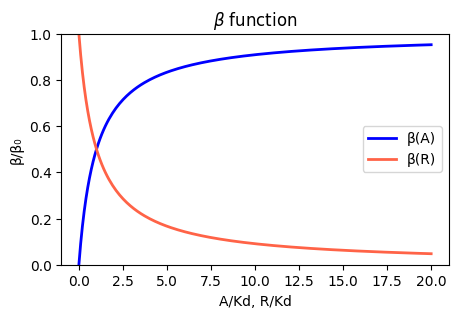

In [ ]:
# 4
A = np.linspace(0, 20, 200)
R = np.linspace(0, 20, 200)
beta_A = A / (1 + A)
beta_R = 1 / (1 + R)

# Build plot
plt.figure(figsize=(5,3))
plt.title(r"$\beta$ function")
plt.xlabel("A/Kd, R/Kd")
plt.ylabel("β/β₀")
plt.plot(A, beta_A,
    linewidth=2,
    color="blue",
    label="β(A)")
plt.plot(R, beta_R,
    linewidth=2,
    color="tomato",
    label="β(R)")
plt.ylim(0, 1)
plt.legend()
plt.show()

## Activator vs. Repressor – which to choose?

We have reached a central design question:

> **_Question:_** The cell has at least two different ways to regulate a gene: using an activator or using a repressor. Which should it choose? Which would you choose if you were designing a synthetic circuit? Why? Are they completely equivalent ways to regulate a target gene? Is one better in some or all conditions? How could we know?  

These questions were  posed in a [study by Michael Savageau (PNAS, 1974)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC388476/), who tried to explain the naturally observed usage of activation and repression in bacteria. A different explanation was later developed by [Shinar et al (PNAS 2004)](https://doi.org/10.1073/pnas.0506610103). We end the lecture with this question - try to think about when and why you would use each type of regulation! 



# Further reading

As starting material we highly recommand open courses like:
- The course [Biological Circuit Design](http://be150.caltech.edu/2020/content/index.html) at Caltech by Elowitz and Bois. Our course is derived from this course.
- The course [Introduction to Biological Engineering Design](https://ocw.mit.edu/courses/biological-engineering/20-020-introduction-to-biological-engineering-design-spring-2009/index.htm) at MIT by Kuldell and Endy

